<a href="https://colab.research.google.com/github/AdaTsang0319/study/blob/master/Run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd gdrive/My\ Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [4]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.4.1
Hub version: 0.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [6]:
module_selection = ("mobilenet_v3_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://hub.tensorflow.google.cn/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://hub.tensorflow.google.cn/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5 with input size (224, 224)


In [7]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    "./food41/images", subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    "./food41/images", subset="training", shuffle=True, **dataflow_kwargs)

Found 19197 images belonging to 134 classes.
Found 76862 images belonging to 134 classes.


In [8]:
do_fine_tuning = False

In [9]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://hub.tensorflow.google.cn/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1024)              1529968   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 134)               137350    
Total params: 1,667,318
Trainable params: 137,350
Non-trainable params: 1,529,968
_________________________________________________________________


In [10]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [11]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
1899/2401 [======================>.......] - ETA: 2:17:58 - loss: 3.5476 - accuracy: 0.2988

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2401/2401 [==============================] - 48095s 20s/step - loss: 3.4273 - accuracy: 0.3247 - val_loss: 2.4825 - val_accuracy: 0.5433
Epoch 2/5
2401/2401 [==============================] - 734s 306ms/step - loss: 2.4502 - accuracy: 0.5423 - val_loss: 2.3753 - val_accuracy: 0.5702
Epoch 3/5
2401/2401 [==============================] - 714s 297ms/step - loss: 2.3196 - accuracy: 0.5829 - val_loss: 2.3406 - val_accuracy: 0.5790
Epoch 4/5
2401/2401 [==============================] - 701s 292ms/step - loss: 2.2846 - accuracy: 0.5948 - val_loss: 2.3175 - val_accuracy: 0.5888
Epoch 5/5
2401/2401 [==============================] - 705s 294ms/step - loss: 2.2356 - accuracy: 0.6114 - val_loss: 2.3089 - val_accuracy: 0.5916


In [15]:
saved_model_path = f"./food41/saved_model"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: ./food41/saved_model/assets


INFO:tensorflow:Assets written to: ./food41/saved_model/assets


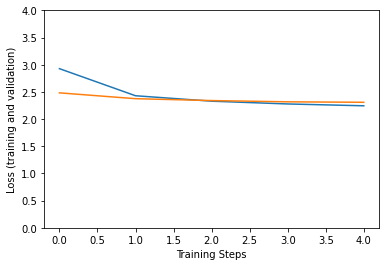

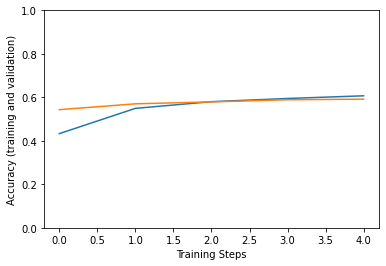

In [19]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

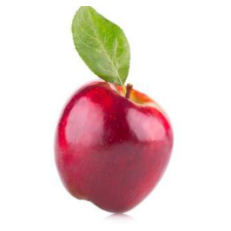

True label: Apples
Predicted label: Apples


In [20]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [22]:
saved_model_path2 = f"./food41/saved_model2"
model.save(saved_model_path2+".h5")

In [30]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 112kB 23.7MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [31]:
!tensorflowjs_converter --input_format=keras \
"./food41/saved_model2.h5" \
"./food41/saved_model3"

2021-04-01 06:22:24.877208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [32]:
optimize_lite_model = False 
num_calibration_examples = 60 
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"./food41/liteModel.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 6626136 bytes.


In [33]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [34]:
num_eval_examples = 50 
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 50 of 50 examples (100%).
TF Lite model is accurate on 31 of 50 examples (62%).


AttributeError: ignored

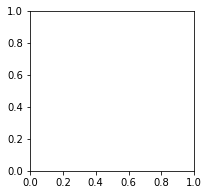

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
sunflower_url = "./food/redBeanPudding10.jpeg"
sunflower_path = tf.keras.utils.get_file('redBeanPudding10.jpeg', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

ValueError: ignored

In [ ]:
cd

/root


In [ ]:
hist.save('./food')

NameError: ignored